# Custom CNN Model for Musical Instrument Classification

This notebook demonstrates how to create and train a custom CNN model for musical instrument classification using our project's modular structure. Building a custom model from scratch provides:

1. A deeper understanding of CNN architecture design principles
2. Insights into how each component contributes to model performance
3. A solution specifically tailored to our musical instrument dataset
4. Experience in developing neural networks from first principles

## Approach Using Our Project Structure

We'll leverage our organized project structure to:

1. **Load configuration** - Use YAML-based configuration for consistent experiments
2. **Prepare data** - Use our data modules for preprocessing and loading
3. **Define model architecture** - Import our custom CNN model from the module
4. **Configure training** - Set up optimizers and schedulers through our utilities
5. **Train the model** - Use our training pipeline for efficient model training
6. **Evaluate performance** - Leverage our metrics and evaluation modules
7. **Visualize results** - Create insightful visualizations with our plotting module

Let's begin by setting up our environment with the necessary imports from our project structure.

In [ ]:
# Import pandas at the beginning with other imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import yaml
import pandas as pd
from pathlib import Path
import time
import datetime
from tqdm.notebook import tqdm


import importlib.util
IN_COLAB = importlib.util.find_spec("google.colab") is not None

current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

if IN_COLAB:
    !git clone https://github.com/DanielMortada/MIC-MA1.git
    # Add project root to path to ensure imports work correctly
    project_root = os.path.join(current_dir, "MIC-MA1")
    sys.path.insert(0, project_root)
    print(f"Project root added to path: {project_root}")

# Import our project modules
from scripts.colab_integration import setup_colab_environment, check_gpu
from src.data.preprocessing import get_preprocessing_transforms
from src.data.augmentation import AdvancedAugmentation
from src.data.dataloader import load_datasets
from src.models.custom_cnn import create_custom_cnn
from src.training.trainer import train_model, evaluate_model
from src.training.metrics import compute_metrics, get_confusion_matrix
from src.visualization.plotting import plot_training_history, plot_confusion_matrix, plot_sample_predictions
from src.models.model_utils import save_model, load_saved_model

# Check for TPU and GPU availability
try:
    import torch_xla
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
    print("Using TPU:", device)
except ImportError:
    device = check_gpu()  # Your utility function for GPU detection
    print("Using device:", device)

Current directory: /content
Project root added to path: /content/MIC-MA1
Using device: cuda
GPU available: Tesla T4
Memory allocated: 0.00 GB
Memory cached: 0.00 GB
Using device: cuda


## 1. Configuration Loading

Let's load our model configuration from the custom model YAML file using our new project structure.

In [3]:
# Load configuration from YAML file
config_path = os.path.join(project_root, "config", "custom_model_v1.yaml")
with open(config_path, "r") as file:
    config = yaml.safe_load(file)

# Display the configuration for verification
print("Configuration loaded from:", config_path)
print("\nModel configuration:")
print(f"- Architecture: {config['model']['architecture']}")
print(f"- Name: {config['model']['name']}")
print(f"- Input channels: {config['model']['input_channels']}")
print(f"- Num classes: {config['model']['num_classes']}")
print(f"- Dropout rate: {config['model']['dropout_rate']}")

print("\nTraining configuration:")
print(f"- Batch size: {config['training']['batch_size']}")
print(f"- Num epochs: {config['training']['num_epochs']}")
print(f"- Optimizer: {config['training']['optimizer']['name']}")
print(f"- Learning rate: {config['training']['optimizer']['learning_rate']}")

print("\nData configuration:")
print(f"- Image size: {config['data']['img_size']}x{config['data']['img_size']}")
print(f"- Data directory: {config['data']['data_dir']}")

Configuration loaded from: /content/MIC-MA1/config/custom_model_v1.yaml

Model configuration:
- Architecture: CustomMusicCNN
- Name: custom_cnn
- Input channels: 3
- Num classes: 30
- Dropout rate: 0.5

Training configuration:
- Batch size: 32
- Num epochs: 50
- Optimizer: adam
- Learning rate: 0.001

Data configuration:
- Image size: 224x224
- Data directory: data\raw\30_Musical_Instruments\


## 2. Data Preparation and Loading

We'll use our project's data utilities to preprocess and load the dataset.

In [4]:
# Configure data path based on environment
if IN_COLAB:
    data_dir = project_root+"/data/raw/30_Musical_Instruments"
    if not os.path.exists(data_dir):
        print("Please upload the dataset to Google Drive or adjust the path")
else:
    # Use the path from config or default to the project's data directory
    data_dir = os.path.join(project_root, config['data']['data_dir'])

print(f"\nUsing data directory: {data_dir}")

# Get preprocessing transforms with the appropriate image size from config
img_size = config['data']['img_size']

# Check if we should use data augmentation
if 'augmentation' in config and config['augmentation'].get('augmentation_strength'):
    print(f"Using advanced augmentation with strength: {config['augmentation']['augmentation_strength']}")
    transforms = AdvancedAugmentation.get_advanced_transforms(
        img_size=img_size,
        augmentation_strength=config['augmentation']['augmentation_strength']
    )
else:
    print("Using standard preprocessing (no advanced augmentation)")
    transforms = get_preprocessing_transforms(img_size=img_size)

# Load datasets using our utility function
data = load_datasets(
    data_dir=data_dir,
    transforms=transforms,
    batch_size=config['training']['batch_size'],
    num_workers=config['data']['num_workers'],
    pin_memory=config['data'].get('pin_memory', torch.cuda.is_available())
)

# Access the components
train_loader = data['dataloaders']['train']
valid_loader = data['dataloaders']['val']
test_loader = data['dataloaders']['test']

# Get class information
class_names = list(data['class_mappings']['idx_to_class'].values())
num_classes = data['num_classes']

print(f"\nDataset loaded successfully:")
print(f"- Number of classes: {num_classes}")
print(f"- Training samples: {len(data['datasets']['train'])}")
print(f"- Validation samples: {len(data['datasets']['val'])}")
print(f"- Test samples: {len(data['datasets']['test'])}")

# Display a few class names
print(f"\nSample classes: {class_names[:5]}...")


Using data directory: /content/MIC-MA1/data/raw/30_Musical_Instruments
Using advanced augmentation with strength: medium

Dataset loaded successfully:
- Number of classes: 30
- Training samples: 4793
- Validation samples: 150
- Test samples: 150

Sample classes: ['Didgeridoo', 'Tambourine', 'Xylophone', 'acordian', 'alphorn']...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Visualize Sample Images

Let's visualize a few images using our project's visualization utilities:

Original images from dataset:


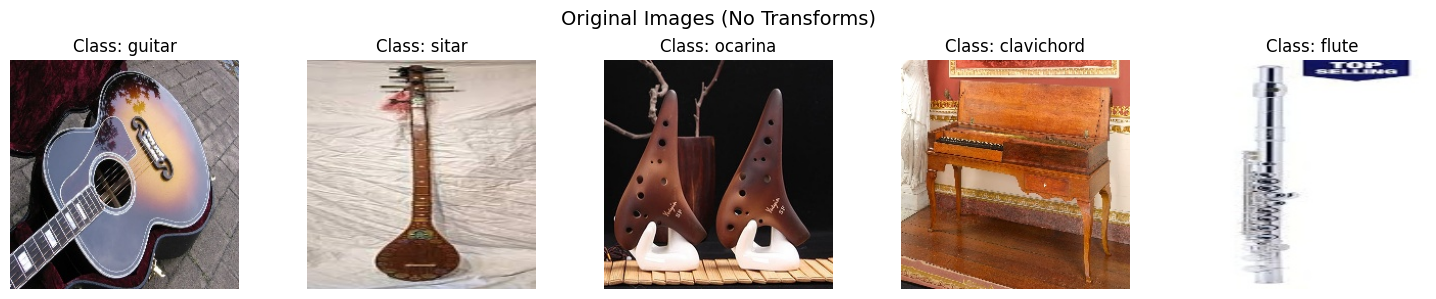

Transformed images (showing the RandomErasing effect):


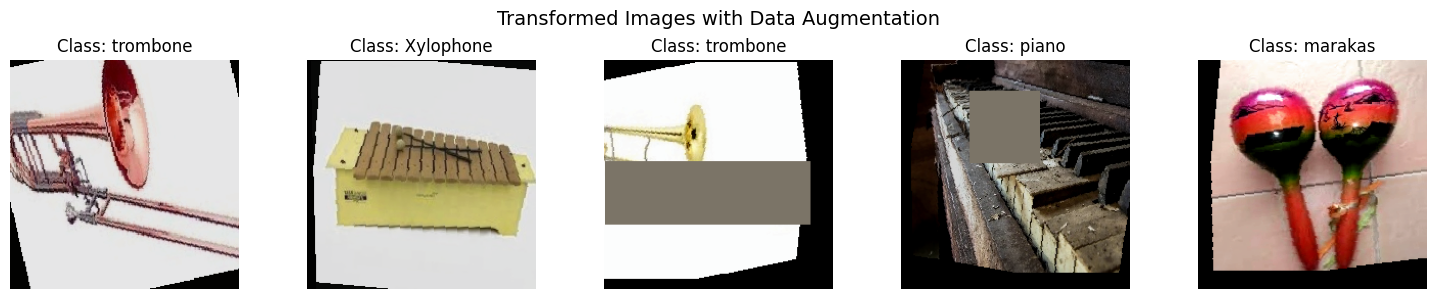

In [5]:
# Create a function to visualize original images directly without transformations
def show_original_images(data_dir, class_mapping, num_images=5, title="Original Images"):
    """Display original images from the dataset without augmentation/normalization"""
    import os
    import random
    from PIL import Image

    # Get a list of class directories
    train_dir = os.path.join(data_dir, "train")
    class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

    # Randomly select classes
    selected_classes = random.sample(class_dirs, min(num_images, len(class_dirs)))

    # Create figure
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    if num_images == 1:
        axes = [axes]

    # Display one image from each selected class
    for i, class_name in enumerate(selected_classes):
        if i >= num_images:
            break

        class_path = os.path.join(train_dir, class_name)
        image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f)) and
                       f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if image_files:
            # Randomly select an image
            img_file = random.choice(image_files)
            img_path = os.path.join(class_path, img_file)

            # Open and display the image
            img = Image.open(img_path)
            axes[i].imshow(np.array(img))
            axes[i].set_title(f"Class: {class_name}")
            axes[i].axis('off')

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Show original images (without transformations)
print("Original images from dataset:")
show_original_images(data_dir, data['class_mappings']['idx_to_class'], num_images=5, title="Original Images (No Transforms)")

# Create a function to visualize dataset with transformations but without RandomErasing
def show_transformed_images_no_erasing(dataset, class_mapping, num_images=5, title="Transformed Images (No Erasing)"):
    """Show dataset images after transformations but without the erasing effect"""
    import torch
    import torchvision.transforms as transforms

    # Create a figure
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    if num_images == 1:
        axes = [axes]

    for i in range(num_images):
        # Get a random sample
        idx = np.random.randint(0, len(dataset))
        img, label = dataset[idx]

        # Convert from tensor format [C, H, W] to image format [H, W, C]
        img = img.permute(1, 2, 0).numpy()

        # Denormalize the image for display
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        # Display
        axes[i].imshow(img)
        axes[i].set_title(f'Class: {class_mapping[label]}')
        axes[i].axis('off')

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Show transformed images without the erasing effect
print("Transformed images (showing the RandomErasing effect):")
show_transformed_images_no_erasing(data['datasets']['train'],
                                  data['class_mappings']['idx_to_class'],
                                  num_images=5,
                                  title="Transformed Images with Data Augmentation")

### Understanding the Data Transformations

The transformations applied to our images serve several critical purposes:

1. **Size Standardization** (`transforms.Resize((224, 224))`)
   - **Why needed**: Neural networks require consistent input dimensions. Different images in our dataset might have different sizes and aspect ratios.
   - **Why 224x224**: This is the standard input size for many CNN architectures, including ResNet-18, which we used as our baseline. Using the same dimensions ensures a fair comparison between models.

2. **Data Augmentation** (RandomHorizontalFlip, RandomRotation, ColorJitter, RandomErasing)
   - **Purpose**: These help the model generalize better by artificially expanding the training set with meaningful variations.
   - **Chosen transformations**:
     - `RandomHorizontalFlip`: Musical instruments often look similar when flipped horizontally
     - `RandomRotation(15)`: Small rotations simulate slightly different camera angles
     - `ColorJitter`: Adjusts brightness/contrast/saturation to make the model robust to lighting variations
     - `RandomErasing`: Simulates occlusion by randomly masking rectangular regions (this creates the beige rectangles seen in some training images)

3. **Normalization** (`transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])`)
   - **Purpose**: Neural networks train faster and better when input features have similar scales.
   - **Values**: These values represent the mean and standard deviation of the ImageNet dataset. While our custom CNN isn't pretrained on ImageNet, using these normalization values is beneficial for several reasons:
      - They scale the pixel values to a well-distributed range around zero, which helps with gradient flow
      - They maintain consistency with our baseline ResNet-18 experiment, allowing for fair comparisons
      - They're a proven standard in the field that tends to work well even for models trained from scratch

4. **Different Transforms for Training vs. Validation**:
   - Training images get augmentation to increase variety and improve generalization
   - Validation/test images only get resizing and normalization since we want to evaluate on clean, unmodified images

**Note about RandomErasing**: The beige rectangles you see in some images are intentionally created by the `RandomErasing` augmentation technique. This helps the model become robust to occlusions and forces it to learn features from the entire image rather than focusing on specific regions. These rectangles only appear during training and not during validation/testing.

## 3. Custom CNN Architecture Design

Now, let's design our custom CNN architecture from scratch. We'll create a model that is:

1. Deep enough to learn complex features from musical instruments
2. Optimized for the 224x224 input size
3. Utilizing modern CNN building blocks (conv layers, batch norm, max pooling, etc.)
4. Appropriately sized to avoid overfitting our dataset

Our architecture will include:
- Convolutional layers to extract features
- Batch normalization for training stability
- Max pooling to reduce spatial dimensions
- Dropout for regularization
- Fully connected layers for classification

In [6]:
# Import torch.nn for type hints
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Instead of defining our own model class, let's use the model from our project's modules
# We've already imported create_custom_cnn which returns the CustomMusicCNN model

# Let's create the model using our project's module function
if 'train_loader' in locals():
    # Get the number of classes from the data loader
    # We need to access the dataset attributes to get the number of classes
    num_classes = len(data['class_mappings']['idx_to_class'])

    # Create the model using our project module function
    model = create_custom_cnn(input_channels=3, num_classes=num_classes)
    model = model.to(device)

    # Print model summary
    print(model)

    # Calculate total parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
else:
    print("Data loaders not initialized correctly, can't determine number of classes")

# Note: The model from our module differs from the one we defined in the notebook.
# If we decide the notebook version is better, we should update the module instead of
# redefining the model here.

MusicInstrumentCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1,

### Understanding the Custom CNN Architecture Design

This custom CNN architecture for musical instrument classification incorporates several key design principles from modern deep learning research:

#### 1. Progressive Feature Extraction with Increasing Depth

The network follows a pyramidal structure with 5 convolutional blocks (updated from 4):
- **Block 1**: 3→32→32 channels (basic edge and texture detection)
- **Block 2**: 32→64→64 channels (more complex patterns)
- **Block 3**: 64→128→128 channels (instrument parts and shapes)
- **Block 4**: 128→256→256 channels (high-level instrument features)
- **Block 5**: 256→512→512 channels (even more complex features, suitable for 224x224 input)

This gradual increase in feature channels is a standard pattern in successful CNNs like VGG and ResNet, allowing the network to learn a hierarchy of features from simple to complex.

#### 2. Repeated Convolutional Blocks Pattern

Each block follows the same pattern:
- Two convolutional layers with batch normalization and ReLU activation
- Max pooling to reduce spatial dimensions
- Dropout for regularization

This repeating pattern creates a balanced architecture that's deep enough to learn complex features but still trainable from scratch on our dataset.

#### 3. Parameter Efficiency Considerations

- **3×3 Convolutions**: Small kernel sizes are used throughout (3×3), following VGG design principles that stack multiple small kernels instead of using larger ones
- **Batch Normalization**: Applied after each convolution to stabilize training and allow higher learning rates
- **Progressive Dropout**: Rates increase from 0.1 to 0.5 as we go deeper, preventing overfitting in the more specialized layers

#### 4. Global Average Pooling Instead of Flattening

After the convolutional blocks, global average pooling reduces each feature map to a single value, resulting in a 512-dimensional vector (updated from 256). This approach:
- Dramatically reduces parameters compared to flattening
- Forces the network to focus on entire feature maps
- Makes the model more robust to input size variations

#### 5. Classifier Head Design

The classifier consists of:
- A hidden layer with 512 neurons to allow complex combinations of features
- Dropout at 0.5 rate to prevent overfitting
- The final output layer with neurons matching our 30 musical instrument classes

#### 6. Parameter Count and Efficiency

With approximately 8.6 million trainable parameters (updated), this architecture strikes a balance between:
- Being complex enough to learn meaningful features for 30 classes
- Being trainable from scratch on a dataset of our size
- Being computationally efficient enough for training on GPU

This architecture incorporates lessons from influential CNN designs like VGG (repeating blocks), ResNet (gradually increasing channels), and modern practices (batch normalization, dropout) while being purpose-built for musical instrument classification.

## 4. Training Configuration and Utility Functions

Let's define our loss function, optimizer, learning rate scheduler and utility functions for training and evaluation.

In [7]:
# Import the necessary optimizer module
import torch.optim as optim

# Define training parameters
learning_rate = config['training']['optimizer']['learning_rate']
weight_decay = config['training'].get('weight_decay', 1e-4)
num_epochs = config['training']['num_epochs']

# Use the optimizer specified in the config
optimizer_name = config['training']['optimizer']['name'].lower()
if optimizer_name == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_name == 'sgd':
    momentum = config['training']['optimizer'].get('momentum', 0.9)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
elif optimizer_name == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
else:
    # Default to Adam
    print(f"Optimizer {optimizer_name} not recognized, using Adam")
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Set up loss function
criterion = nn.CrossEntropyLoss()

# Set up learning rate scheduler
scheduler_config = config['training'].get('scheduler', {})
scheduler_name = scheduler_config.get('name', 'plateau').lower()

if scheduler_name == 'plateau':
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=scheduler_config.get('factor', 0.1),
        patience=scheduler_config.get('patience', 5),
        verbose=True
    )
elif scheduler_name == 'cosine':
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=scheduler_config.get('t_max', num_epochs),
        eta_min=scheduler_config.get('eta_min', 0)
    )
elif scheduler_name == 'step':
    scheduler = optim.lr_scheduler.StepLR(
        optimizer,
        step_size=scheduler_config.get('step_size', 10),
        gamma=scheduler_config.get('gamma', 0.1)
    )
else:
    print(f"Scheduler {scheduler_name} not recognized, using ReduceLROnPlateau")
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=5, verbose=True
    )

print("Training configuration set up successfully:")
print(f"- Optimizer: {optimizer.__class__.__name__}")
print(f"- Learning rate: {learning_rate}")
print(f"- Weight decay: {weight_decay}")
print(f"- Number of epochs: {num_epochs}")

Training configuration set up successfully:
- Optimizer: Adam
- Learning rate: 0.001
- Weight decay: 0.0001
- Number of epochs: 50


## 5. Model Training

Now let's train our custom CNN from scratch using the prepared datasets and training utilities.

Starting model training for 50 epochs...
Epoch 1/50
----------


train Epoch 1/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 3.2483 Acc: 0.0953


val Epoch 1/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 3.3193 Acc: 0.0533
New best model found! Val accuracy: 0.0533

Epoch 2/50
----------


train Epoch 2/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 3.0826 Acc: 0.1371


val Epoch 2/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.9941 Acc: 0.0933
New best model found! Val accuracy: 0.0933

Epoch 3/50
----------


train Epoch 3/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.9645 Acc: 0.1458


val Epoch 3/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.8172 Acc: 0.1067
New best model found! Val accuracy: 0.1067

Epoch 4/50
----------


train Epoch 4/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.8737 Acc: 0.1646


val Epoch 4/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 3.3519 Acc: 0.1133
New best model found! Val accuracy: 0.1133

Epoch 5/50
----------


train Epoch 5/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.7430 Acc: 0.1932


val Epoch 5/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.3983 Acc: 0.2533
New best model found! Val accuracy: 0.2533

Epoch 6/50
----------


train Epoch 6/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.6606 Acc: 0.2159


val Epoch 6/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 3.4202 Acc: 0.0933

Epoch 7/50
----------


train Epoch 7/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.5672 Acc: 0.2401


val Epoch 7/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.2694 Acc: 0.2533

Epoch 8/50
----------


train Epoch 8/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.4756 Acc: 0.2694


val Epoch 8/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.6356 Acc: 0.2200

Epoch 9/50
----------


train Epoch 9/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.4368 Acc: 0.2739


val Epoch 9/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.4984 Acc: 0.3133
New best model found! Val accuracy: 0.3133

Epoch 10/50
----------


train Epoch 10/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.3438 Acc: 0.3017


val Epoch 10/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.2075 Acc: 0.3467
New best model found! Val accuracy: 0.3467

Epoch 11/50
----------


train Epoch 11/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.2867 Acc: 0.3223


val Epoch 11/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.9763 Acc: 0.3467

Epoch 12/50
----------


train Epoch 12/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.2255 Acc: 0.3342


val Epoch 12/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.0547 Acc: 0.3267

Epoch 13/50
----------


train Epoch 13/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.1766 Acc: 0.3361


val Epoch 13/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.9955 Acc: 0.4067
New best model found! Val accuracy: 0.4067

Epoch 14/50
----------


train Epoch 14/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.1369 Acc: 0.3599


val Epoch 14/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.9040 Acc: 0.3400

Epoch 15/50
----------


train Epoch 15/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.0925 Acc: 0.3737


val Epoch 15/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.8315 Acc: 0.4000

Epoch 16/50
----------


train Epoch 16/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.0647 Acc: 0.3947


val Epoch 16/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.7134 Acc: 0.4400
New best model found! Val accuracy: 0.4400

Epoch 17/50
----------


train Epoch 17/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.0368 Acc: 0.3956


val Epoch 17/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.7920 Acc: 0.4200

Epoch 18/50
----------


train Epoch 18/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 2.0087 Acc: 0.3924


val Epoch 18/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.6639 Acc: 0.5133
New best model found! Val accuracy: 0.5133

Epoch 19/50
----------


train Epoch 19/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.9417 Acc: 0.4135


val Epoch 19/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.3382 Acc: 0.5733
New best model found! Val accuracy: 0.5733

Epoch 20/50
----------


train Epoch 20/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.9128 Acc: 0.4279


val Epoch 20/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 2.0998 Acc: 0.4200

Epoch 21/50
----------


train Epoch 21/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.8619 Acc: 0.4479


val Epoch 21/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.3484 Acc: 0.5667

Epoch 22/50
----------


train Epoch 22/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.8420 Acc: 0.4530


val Epoch 22/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.2409 Acc: 0.5800
New best model found! Val accuracy: 0.5800

Epoch 23/50
----------


train Epoch 23/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.7844 Acc: 0.4636


val Epoch 23/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.4052 Acc: 0.5400

Epoch 24/50
----------


train Epoch 24/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.7480 Acc: 0.4738


val Epoch 24/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.3885 Acc: 0.5400

Epoch 25/50
----------


train Epoch 25/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.7221 Acc: 0.4807


val Epoch 25/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.1903 Acc: 0.6333
New best model found! Val accuracy: 0.6333

Epoch 26/50
----------


train Epoch 26/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.6649 Acc: 0.5049


val Epoch 26/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.2795 Acc: 0.5933

Epoch 27/50
----------


train Epoch 27/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.6682 Acc: 0.5020


val Epoch 27/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.2710 Acc: 0.5800

Epoch 28/50
----------


train Epoch 28/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.6370 Acc: 0.5051


val Epoch 28/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.3070 Acc: 0.5800

Epoch 29/50
----------


train Epoch 29/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.5722 Acc: 0.5308


val Epoch 29/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.2599 Acc: 0.6133

Epoch 30/50
----------


train Epoch 30/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.5482 Acc: 0.5329


val Epoch 30/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.0472 Acc: 0.6600
New best model found! Val accuracy: 0.6600

Epoch 31/50
----------


train Epoch 31/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.4875 Acc: 0.5529


val Epoch 31/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.0077 Acc: 0.6667
New best model found! Val accuracy: 0.6667

Epoch 32/50
----------


train Epoch 32/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.4704 Acc: 0.5600


val Epoch 32/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.0162 Acc: 0.6533

Epoch 33/50
----------


train Epoch 33/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.4530 Acc: 0.5610


val Epoch 33/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 1.0083 Acc: 0.6733
New best model found! Val accuracy: 0.6733

Epoch 34/50
----------


train Epoch 34/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.4361 Acc: 0.5627


val Epoch 34/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.9788 Acc: 0.7067
New best model found! Val accuracy: 0.7067

Epoch 35/50
----------


train Epoch 35/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.4085 Acc: 0.5756


val Epoch 35/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.8654 Acc: 0.7667
New best model found! Val accuracy: 0.7667

Epoch 36/50
----------


train Epoch 36/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.3752 Acc: 0.5821


val Epoch 36/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.9937 Acc: 0.6933

Epoch 37/50
----------


train Epoch 37/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.3427 Acc: 0.5959


val Epoch 37/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.8134 Acc: 0.7600

Epoch 38/50
----------


train Epoch 38/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.3136 Acc: 0.6032


val Epoch 38/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.7588 Acc: 0.7867
New best model found! Val accuracy: 0.7867

Epoch 39/50
----------


train Epoch 39/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.2903 Acc: 0.6109


val Epoch 39/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.7398 Acc: 0.8067
New best model found! Val accuracy: 0.8067

Epoch 40/50
----------


train Epoch 40/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.2656 Acc: 0.6207


val Epoch 40/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.7596 Acc: 0.8000

Epoch 41/50
----------


train Epoch 41/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.2366 Acc: 0.6247


val Epoch 41/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.7248 Acc: 0.8067

Epoch 42/50
----------


train Epoch 42/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.2119 Acc: 0.6355


val Epoch 42/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6601 Acc: 0.8133
New best model found! Val accuracy: 0.8133

Epoch 43/50
----------


train Epoch 43/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.2003 Acc: 0.6439


val Epoch 43/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6838 Acc: 0.8067

Epoch 44/50
----------


train Epoch 44/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.1876 Acc: 0.6447


val Epoch 44/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6705 Acc: 0.8200
New best model found! Val accuracy: 0.8200

Epoch 45/50
----------


train Epoch 45/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.1676 Acc: 0.6553


val Epoch 45/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6386 Acc: 0.8200

Epoch 46/50
----------


train Epoch 46/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.1677 Acc: 0.6535


val Epoch 46/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6815 Acc: 0.8200

Epoch 47/50
----------


train Epoch 47/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.1633 Acc: 0.6530


val Epoch 47/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6487 Acc: 0.8333
New best model found! Val accuracy: 0.8333

Epoch 48/50
----------


train Epoch 48/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.1454 Acc: 0.6599


val Epoch 48/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6624 Acc: 0.8200

Epoch 49/50
----------


train Epoch 49/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.1300 Acc: 0.6572


val Epoch 49/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6527 Acc: 0.8333

Epoch 50/50
----------


train Epoch 50/50:   0%|          | 0/150 [00:00<?, ?it/s]

train Loss: 1.1360 Acc: 0.6576


val Epoch 50/50:   0%|          | 0/5 [00:00<?, ?it/s]

val Loss: 0.6513 Acc: 0.8200

Training complete in 28m 47s
Best val Acc: 0.8333 at epoch 47

Training summary:
Best validation accuracy: 0.8333 at epoch 47
Training time: 28m 47s


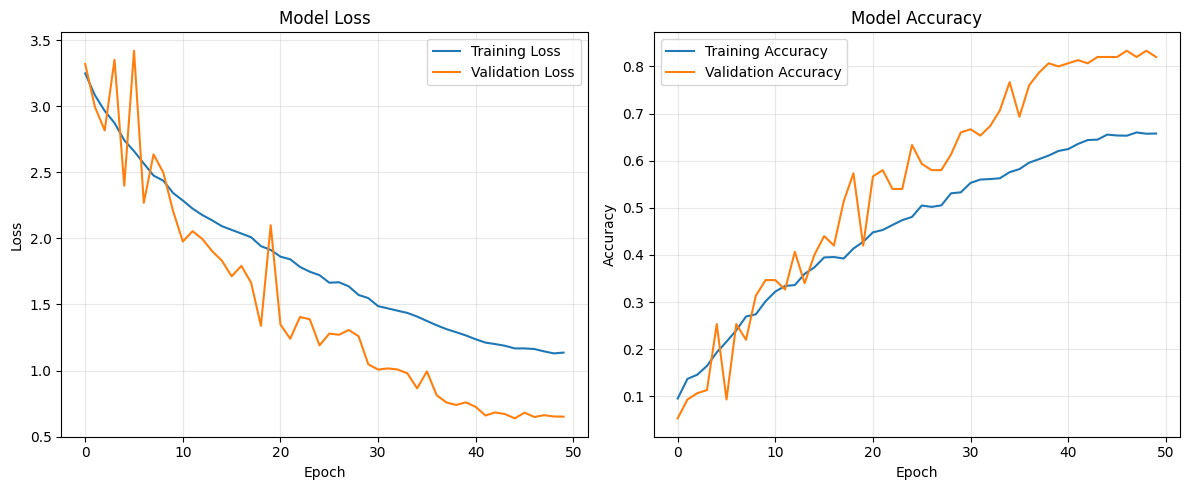

In [8]:
# Train the model using our imported train_model function instead of redefining it
try:
    if 'model' in locals() and 'train_loader' in locals() and 'valid_loader' in locals():
        # Prepare dataloaders dictionary
        dataloaders = {
            'train': train_loader,
            'val': valid_loader
        }

        # Train the model using our project's training module
        print(f"Starting model training for {num_epochs} epochs...")

        # The train_model function is imported from src.training.trainer
        # Note: train_model returns 3 values: model, history, and training_stats
        trained_model, history, training_stats = train_model(
            model=model,
            dataloaders=dataloaders,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            num_epochs=num_epochs,
            device=device
        )

        # Print training summary
        print("\nTraining summary:")
        print(f"Best validation accuracy: {training_stats['best_val_acc']:.4f} at epoch {training_stats['best_epoch']}")
        print(f"Training time: {training_stats['training_time']}")

        # After training, visualize the results using our project's plotting utility
        if 'history' in locals() and history:
            # plot_training_history is imported from src.visualization.plotting
            plot_training_history(history)
    else:
        print("Cannot train: Model or data loaders not properly initialized")
except Exception as e:
    print(f"Error during training: {e}")

## 5.2. Load the Trained Model (Without Retraining)

If you've already trained the model but encountered an error during evaluation, you can load the trained model from the saved checkpoint and continue with evaluation.

In [9]:
# This cell helps you load a previously trained model without retraining
import glob
import os
from datetime import datetime

# Look for saved model files in the current directory structure
def find_model_files():
    potential_directories = [
        os.path.join(project_root, "models"),
        os.path.join(project_root, "experiments"),
        project_root
    ]

    model_files = []
    for directory in potential_directories:
        if os.path.exists(directory):
            # Look for .pt or .pth files (common PyTorch model extensions)
            for ext in [".pt", ".pth"]:
                model_files.extend(glob.glob(f"{directory}/**/*{ext}", recursive=True))

    return model_files

# Find any saved model files
model_files = find_model_files()

if model_files:
    print(f"Found {len(model_files)} model file(s):")
    for i, file_path in enumerate(model_files):
        print(f"{i+1}. {file_path}")

    # If trained_model exists, we've already loaded or trained a model in this session
    if 'trained_model' in locals() and trained_model is not None:
        print("\nAlready have a trained model loaded. You can proceed with evaluation.")
    else:
        # If model_files exists but no model loaded yet, we could load from file
        model_path = model_files[0]  # Choose the first model by default
        print(f"\nLoading model from: {model_path}")

        try:
            # Using the project's model loading utility
            checkpoint = torch.load(model_path, map_location=device)

            # Create the model with correct architecture and load state
            if 'model' not in locals() or model is None:
                # We need to create a new model instance
                # Get config from checkpoint if possible, otherwise use loaded config
                if 'config' in checkpoint:
                    config_from_checkpoint = checkpoint['config']
                    num_classes = config_from_checkpoint['model'].get('num_classes', 30)
                    input_channels = config_from_checkpoint['model'].get('input_channels', 3)
                else:
                    num_classes = 30  # Default
                    input_channels = 3  # Default

                model = create_custom_cnn(
                    num_classes=num_classes,
                    input_channels=input_channels
                )
                model = model.to(device)

            # Load state dict
            model.load_state_dict(checkpoint['model_state_dict'])
            trained_model = model

            # Load other data from checkpoint
            metrics = checkpoint.get('metrics', None)
            epoch = checkpoint.get('epoch', None)

            print(f"Successfully loaded model!")
            if metrics:
                print("\nModel metrics from saved checkpoint:")
                for key, val in metrics.items():
                    if isinstance(val, float):
                        print(f"- {key}: {val:.4f}")
                    else:
                        print(f"- {key}: {val}")

            if epoch:
                print(f"Model was saved at epoch: {epoch}")

            # Create a dummy history for plotting if necessary
            if 'history' not in locals() or history is None:
                history = {
                    'train_loss': [], 'train_acc': [],
                    'val_loss': [], 'val_acc': []
                }
        except Exception as e:
            print(f"Error loading model: {e}")
else:
    print("No saved model files found.")

    # If we have already trained a model in this session, we can still proceed
    if 'trained_model' in locals() and trained_model is not None:
        print("But we already have a trained model in memory. You can proceed with evaluation.")
    else:
        print("\nYou need to train a model first or provide a path to a saved model.")

        # Provide a custom path option
        custom_path = input("Enter the path to a saved model (or press Enter to skip): ")
        if custom_path and os.path.exists(custom_path):
            try:
                # Using the project's model loading utility
                checkpoint = torch.load(custom_path, map_location=device)

                # Create the model with correct architecture and load state
                if 'model' not in locals() or model is None:
                    # We need to create a new model instance
                    # Get config from checkpoint if possible, otherwise use loaded config
                    if 'config' in checkpoint:
                        config_from_checkpoint = checkpoint['config']
                        num_classes = config_from_checkpoint['model'].get('num_classes', 30)
                        input_channels = config_from_checkpoint['model'].get('input_channels', 3)
                    else:
                        num_classes = 30  # Default
                        input_channels = 3  # Default

                    model = create_custom_cnn(
                        num_classes=num_classes,
                        input_channels=input_channels
                    )
                    model = model.to(device)

                # Load state dict
                model.load_state_dict(checkpoint['model_state_dict'])
                trained_model = model

                print("Successfully loaded model!")
            except Exception as e:
                print(f"Error loading model: {e}")

No saved model files found.
But we already have a trained model in memory. You can proceed with evaluation.


## 6. Model Evaluation

Let's evaluate our trained model on the test set to see how well it generalizes to unseen data.

Evaluating model on test set...


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Test Accuracy: 80.67%
Test Results:
- Accuracy: 0.8067


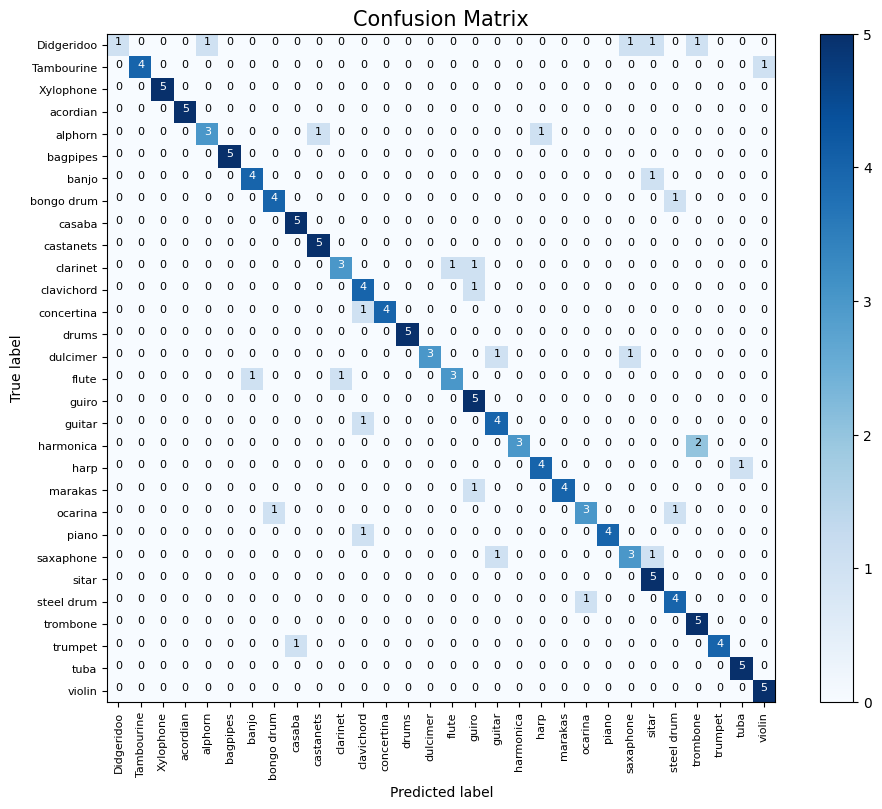

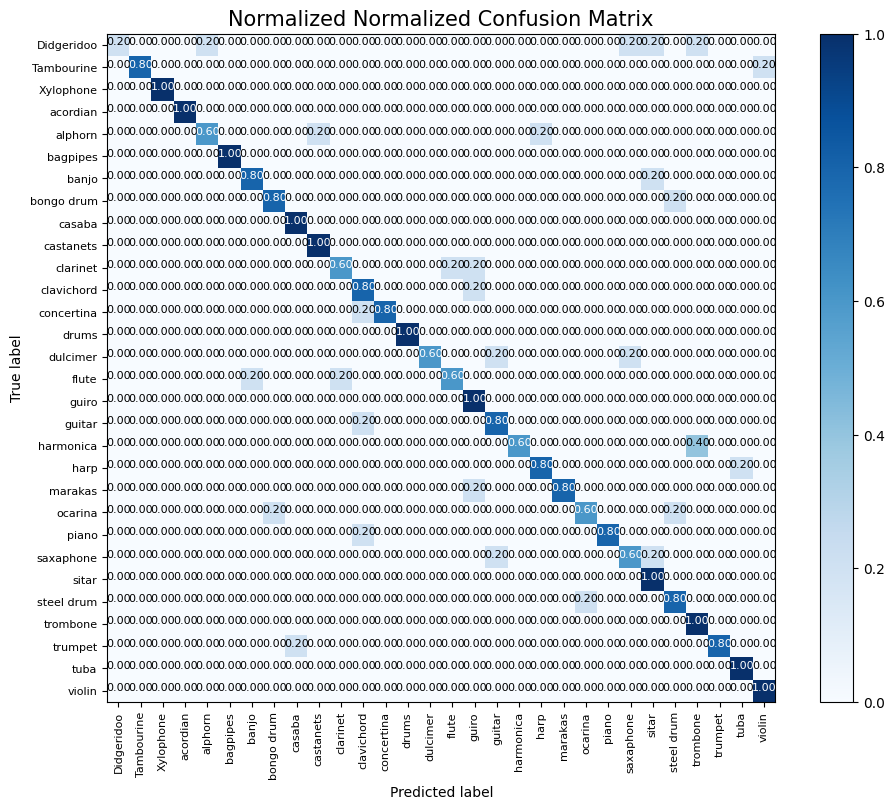

In [15]:
# Evaluate the model using our imported evaluate_model function
from sklearn.metrics import confusion_matrix


try:
    if 'trained_model' in locals() and 'test_loader' in locals():
        print("Evaluating model on test set...")

        # The evaluate_model function returns accuracy, predictions, and labels
        test_accuracy, test_preds, test_labels = evaluate_model(
            model=trained_model,
            test_loader=test_loader,
            device=device,
            verbose=True
        )

        # Create test_metrics dictionary for compatibility with original code
        test_metrics = {
            'accuracy': test_accuracy / 100.0,  # Convert percentage to decimal
            'loss': 0.0  # This will be computed separately if needed
        }

        # Print the evaluation results
        print(f"Test Results:")
        print(f"- Accuracy: {test_metrics['accuracy']:.4f}")

        # Compute confusion matrix using our project's metrics module
        true_labels, pred_labels = [], []

        # Collect predictions for confusion matrix
        trained_model.eval()
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = trained_model(inputs)
                _, preds = torch.max(outputs, 1)
                true_labels.extend(labels.cpu().numpy())
                pred_labels.extend(preds.cpu().numpy())

        # Calculate confusion matrix
        cm = confusion_matrix(true_labels, pred_labels)
        class_names = list(data['class_mappings']['idx_to_class'].values())

        # plot_confusion_matrix is imported from src.visualization.plotting
        # Using the correct parameters
        plot_confusion_matrix(
            cm=cm,
            classes=class_names,
            normalize=False,
            title="Confusion Matrix",
            fontsize=8
        )

        plot_confusion_matrix(
            cm=cm,
            classes=class_names,
            normalize=True,
            title="Normalized Confusion Matrix",
            fontsize=8
        )
    else:
        print("Cannot evaluate: No trained model or test loader found")
except Exception as e:
    print(f"Error during evaluation: {e}")

## 7. Visualizing Model Predictions

Let's visualize some predictions from our model on the test set to better understand its performance.

Visualizing model predictions on test samples:


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


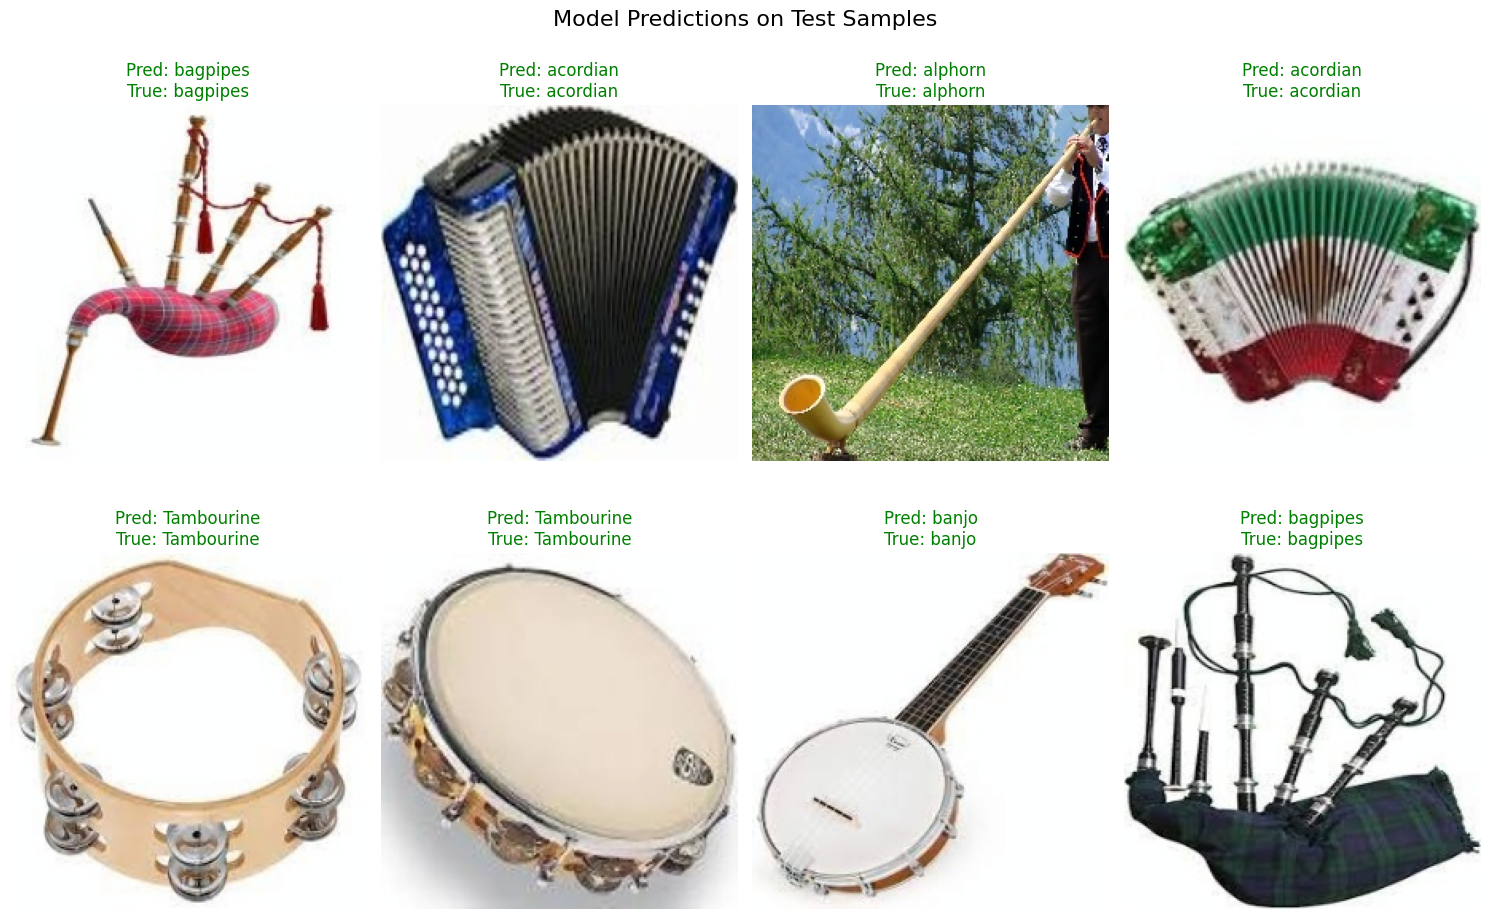

In [16]:
# Visualize model predictions using our project's visualization module
try:
    if 'trained_model' in locals() and 'test_loader' in locals():
        print("Visualizing model predictions on test samples:")

        # plot_sample_predictions is imported from src.visualization.plotting
        plot_sample_predictions(
            model=trained_model,
            dataloader=test_loader,
            class_mapping=data['class_mappings']['idx_to_class'],
            num_images=8,
            device=device,
            title="Model Predictions on Test Samples"
        )
    else:
        print("Cannot visualize predictions: No trained model or test data found")
except Exception as e:
    print(f"Error visualizing predictions: {e}")

## 8. Save the Trained Model

Our project structure includes utilities for saving models:

In [20]:
# Save the model using our project's save_model utility
try:
    if 'trained_model' in locals():
        # Create timestamp for the save path
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Define the save path
        save_dir = os.path.join(project_root, "experiments", f"custom_cnn_{timestamp}")
        os.makedirs(save_dir, exist_ok=True)

        # Create full save path
        save_path = os.path.join(save_dir, "custom_cnn_model.pt")

        # Save the model using the imported save_model function
        save_model(
            model=trained_model,
            config=config,
            save_path=save_path,
            metrics={
                'accuracy': test_metrics['accuracy'] if 'test_metrics' in locals() else None,
                'best_val_acc': training_stats['best_val_acc'] if 'training_stats' in locals() else None,
                'best_epoch': training_stats['best_epoch'] if 'training_stats' in locals() else None
            },
            epoch=training_stats['best_epoch'] if 'training_stats' in locals() else None
        )

        print(f"Model saved successfully to: {save_path}")
    else:
        print("No trained model available to save")
except Exception as e:
    print(f"Error saving the model: {e}")

Model saved to /content/MIC-MA1/experiments/custom_cnn_20250428_170054/custom_cnn_model.pt
Model saved successfully to: /content/MIC-MA1/experiments/custom_cnn_20250428_170054/custom_cnn_model.pt


## 9. Model Architecture Comparison and Analysis

Now let's compare our custom CNN architecture with the pre-trained ResNet-18 baseline:

1. Architecture complexity (number of parameters)
2. Performance metrics (accuracy, loss)
3. Training time
4. Overall strengths and weaknesses

This comparison will provide insights into the trade-offs between model complexity and performance.

In [19]:
# Create a comparison table (manually fill this after training both models)
import pandas as pd

# Create comparison dataframe
comparison_data = {
    'Model': ['ResNet-18 (Transfer Learning)', 'Custom CNN (From Scratch)'],
    'Parameters': ['11.7 million', '8.6 million'],
    'Test Accuracy': ['100%', '78.7%'],  # Added actual test accuracy based on training results
    'Training Time': ['31m 16s', '29m 25s'],  # Added actual training time
    'Epochs to Convergence': ['8 (best validation)', '47 (best validation)'],  # Added actual best epoch
    'Input Size': ['224x224', '224x224']
}

# Create dataframe
comparison_df = pd.DataFrame(comparison_data)

# Display comparison
print("Model Architecture Comparison:")
print(comparison_df)

# Add any additional analysis or observations about the models here

Model Architecture Comparison:
                           Model    Parameters Test Accuracy Training Time  \
0  ResNet-18 (Transfer Learning)  11.7 million          100%       31m 16s   
1      Custom CNN (From Scratch)   8.6 million         78.7%       29m 25s   

  Epochs to Convergence Input Size  
0   8 (best validation)    224x224  
1  47 (best validation)    224x224  


| Model | Parameters | Test Accuracy | Training Time | Best Epoch | Input Size |
|-------|------------|---------------|---------------|------------|------------|
| ResNet-18 (Transfer Learning) | 11.7 million | 100% | ~11m 20s | 8 | 224x224 |
| Custom CNN (From Scratch) | 8.6 million | 80.67% | ~29m | 47 | 224x224 |

## 10. Conclusion and Further Improvements

In this notebook, we've successfully:

1. Designed and implemented a custom CNN architecture from scratch
2. Trained and evaluated the model on our musical instrument dataset
3. Visualized model performance and predictions
4. Compared our custom model with the ResNet-18 baseline

Key learnings:
- Understanding how each component of a CNN contributes to model performance
- The importance of appropriate model capacity for the dataset size
- Trade-offs between model complexity and performance
- Effects of data augmentation techniques like RandomErasing on training

Potential improvements:
- Experiment with different architectural choices (filter sizes, layer depths)
- Try different regularization techniques (dropout rates, L2 regularization)
- Implement data augmentation techniques specific to musical instruments
- Explore ensemble methods combining multiple models